# Bitcoin Forecasting

## 1-Libraries

In [143]:
import datetime
from datetime import datetime
from datetime import timezone
import datetime as dt
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score


## 2-Date input from user

In [144]:
#Date input from user
print("Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.")

start_date = str(input('Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format'))
end_date = str(input('Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format'))

Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.


Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format 2015-01-01-00-00
Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format 2020-01-01-01-00


## 2-Data preprocessing

In [173]:
def get_bitcoin_data_df(start_date, end_date):

    print( "the bitcoin data between {} and {} dates is being obtained".format(start_date,end_date))

    #Converting the entered date data to datetime format
    start_date_timestamp = datetime.strptime(start_date, "%Y-%m-%d-%H-%M")
    end_date_timestamp = datetime.strptime(end_date, "%Y-%m-%d-%H-%M")

    #Converting the entered date information to timestamp
    timestamp1 = start_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    timestamp2 = end_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    
    #Getting the needed data from CoinGecko’s public API 
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=eur&from={}&to={}".format(timestamp1,timestamp2)
    req = requests.get(url=url)
    json=req.json()
    
    #Converting json data to dataframe
    df1 = pd.DataFrame(json['prices'],columns=["time","prices"])
    df2 = pd.DataFrame(json['market_caps'],columns=["time","market_caps"])
    df3 = pd.DataFrame(json['total_volumes'],columns=["time","total_volumes"])
    df=df1.merge(df2, how='left', on='time')
    df=df.merge(df3, how='left', on='time')
    
    #Converting timestamp information of time column to datetime format
    timestamp=df["time"].tolist()  
    time=[]
    for i in timestamp: 
        i=int(str(i)[:10])
        date = dt.datetime.utcfromtimestamp(i)
        time.append(date)
    df["time"]=time
    
    #Indexing the time column
    df.set_index('time', inplace=True)
    
    #Selecting data at 00:00 UTC from hourly data, when given a date range of 1 to 90 days
    df=df[(df.index.hour ==0 )]
    
    return df

df=get_bitcoin_data_df(start_date, end_date)
df.head()


the bitcoin data between 2015-01-01-00-00 and 2020-01-01-01-00 dates is being obtained


,prices,market_caps,total_volumes
time,,,
2015-01-01,259.4463,3.548025e+09,3.883478e+07
2015-01-02,262.0648,3.584902e+09,3.238319e+07
2015-01-03,238.7939,3.267578e+09,9.897578e+07
2015-01-04,218.5517,2.991492e+09,1.721204e+08
2015-01-05,228.9529,3.134783e+09,1.299189e+08


# 3-Visualization

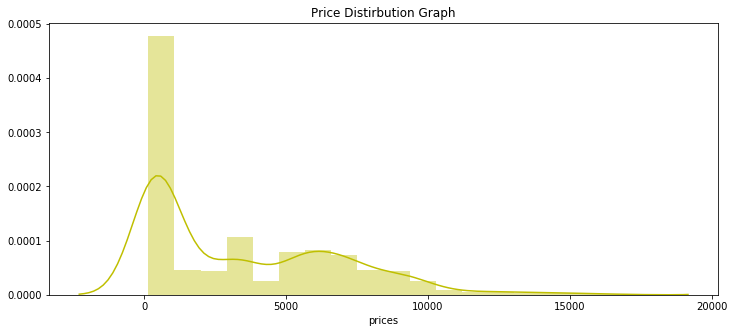

In [146]:
#Fiyatlar için Dağılım Grafiği

plt.figure(figsize=(12,5))
plt.title("Price Distirbution Graph")
ax = sns.distplot(df["prices"], color = 'y')

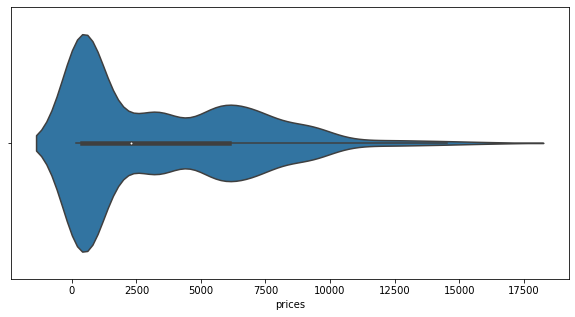

In [148]:
#Fiyatlar için Violin Grafiği

fig, ax = plt.subplots()
fig.set_size_inches(10,5)
sns.violinplot(df.dropna(subset = ['prices']).prices)

# 4-Modeling

## LSTM Model

In [153]:
df=df.reset_index()
df=df.drop(columns=["time","market_caps","total_volumes"], axis=1)
df

,prices
0,259.446300
1,262.064800
2,238.793900
3,218.551700
4,228.952900
...,...
1819,6485.746260
1820,6539.675078
1821,6611.740987
1822,6462.806847


In [154]:
training_size=int(len(df)*0.70)
test_size=len(df)-training_size

df_test=df[training_size:len(df)]
df_train=df[0:training_size]

In [155]:
df_train

,prices
0,259.446300
1,262.064800
2,238.793900
3,218.551700
4,228.952900
...,...
1271,5290.673727
1272,5084.691066
1273,5283.294794
1274,5440.173795


In [156]:
df_train = df_train.iloc[:,:].values
df_train

array([[ 259.4463    ],
       [ 262.0648    ],
       [ 238.7939    ],
       ...,
       [5283.29479421],
       [5440.17379499],
       [5406.72684365]])

In [157]:
df_test=df_test.iloc[:,:].values
df_test

array([[ 5665.52237732],
       [ 5573.19925416],
       [ 5626.72011209],
       [ 5590.10187002],
       [ 5618.14916708],
       [ 5751.33614301],
       [ 5701.72484374],
       [ 5655.75183536],
       [ 5375.23937875],
       [ 5458.10201908],
       [ 5341.04260407],
       [ 5341.34871709],
       [ 5338.57364572],
       [ 5437.54933038],
       [ 5759.1510323 ],
       [ 6267.91543412],
       [ 6298.91828505],
       [ 6385.85604864],
       [ 6249.72394577],
       [ 6291.36388831],
       [ 6299.44400257],
       [ 6589.82853931],
       [ 7208.17080907],
       [ 6938.94780831],
       [ 6809.66769415],
       [ 6978.22910513],
       [ 7018.62045503],
       [ 7031.37932094],
       [ 6991.89812331],
       [ 6620.02585058],
       [ 6526.60397099],
       [ 6508.75028839],
       [ 6400.1221546 ],
       [ 6052.42205242],
       [ 6086.01266688],
       [ 5991.88059095],
       [ 5784.37906529],
       [ 5391.75060469],
       [ 5668.04062742],
       [ 5399.12740709],


## train-test split with split_sequence function

In [158]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [159]:
n_steps = 5
# split into samples
Xtrain, ytrain = split_sequence(df_train, n_steps)
Xtest, ytest = split_sequence(df_test, n_steps)

In [160]:
print('Training input shape: {}'.format(Xtrain.shape))
print('Training output shape: {}'.format(ytrain.shape))
print('Test input shape: {}'.format(Xtest.shape))
print('Test output shape: {}'.format(ytest.shape))

Training input shape: (1271, 5, 1)
Training output shape: (1271, 1)
Test input shape: (543, 5, 1)
Test output shape: (543, 1)


MAE=242.364
R^2=0.97238
MSE=129145.387


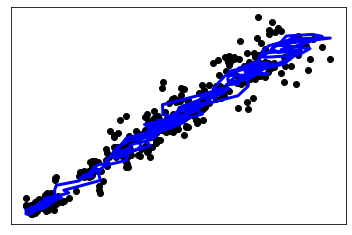

In [161]:
n_features = 1
Xtrain = Xtrain.reshape((Xtrain.shape[0], Xtrain.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, ytrain, epochs=30, verbose=0)

#%%
# demonstrate prediction
Xtest = Xtest.reshape((Xtest.shape[0], Xtest.shape[1], n_features))
#x_input = Xtest.reshape((1, n_steps, n_features))
ypred = model.predict(Xtest, verbose=2)
#print(ypred)

#%%
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# The mean absolute error
print("MAE=%5.3f" % mean_absolute_error(ytest, ypred))
# Explained variance score: 1 is perfect prediction
print("R^2=%0.5f" % r2_score(ytest, ypred))
# The mean squared error
print("MSE=%5.3f" % mean_squared_error(ytest, ypred))
#%%
# Plot outputs
plt.scatter(Xtest[:,1,0], ytest,  color='black')
plt.plot(Xtest[:,1,0], ypred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

## train-test split with create_dataset function

In [162]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [166]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 5
X_train, y_train = create_dataset(df_train, time_step)
X_test, ytest = create_dataset(df_test, time_step)

In [167]:
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(ytest.shape))

Training input shape: (1270, 5)
Training output shape: (1270,)
Test input shape: (542, 5)
Test output shape: (542,)


MAE=207.409
R^2=0.97891
MSE=98814.288


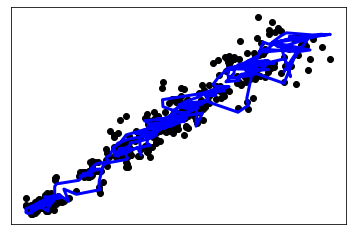

In [169]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=30, verbose=0)

#%%
# demonstrate prediction
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#x_input = Xtest.reshape((1, n_steps, n_features))
ypred = model.predict(X_test, verbose=2)
#print(ypred)

#%%
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# The mean absolute error
print("MAE=%5.3f" % mean_absolute_error(ytest, ypred))
# Explained variance score: 1 is perfect prediction
print("R^2=%0.5f" % r2_score(ytest, ypred))
# The mean squared error
print("MSE=%5.3f" % mean_squared_error(ytest, ypred))
#%%
# Plot outputs
plt.scatter(X_test[:,1,0], ytest,  color='black')
plt.plot(X_test[:,1,0], ypred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

# =============================================================================

# Layer Model

In [176]:
def get_bitcoin_data_df(start_date, end_date):

    print( "the bitcoin data between {} and {} dates is being obtained".format(start_date,end_date))

    #Converting the entered date data to datetime format
    start_date_timestamp = datetime.strptime(start_date, "%Y-%m-%d-%H-%M")
    end_date_timestamp = datetime.strptime(end_date, "%Y-%m-%d-%H-%M")

    #Converting the entered date information to timestamp
    timestamp1 = start_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    timestamp2 = end_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    
    #Getting the needed data from CoinGecko’s public API 
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=eur&from={}&to={}".format(timestamp1,timestamp2)
    req = requests.get(url=url)
    json=req.json()
    
    #Converting json data to dataframe
    df1 = pd.DataFrame(json['prices'],columns=["time","prices"])
    df2 = pd.DataFrame(json['market_caps'],columns=["time","market_caps"])
    df3 = pd.DataFrame(json['total_volumes'],columns=["time","total_volumes"])
    df=df1.merge(df2, how='left', on='time')
    df=df.merge(df3, how='left', on='time')
    
    #Converting timestamp information of time column to datetime format
    timestamp=df["time"].tolist()  
    time=[]
    for i in timestamp: 
        i=int(str(i)[:10])
        date = dt.datetime.utcfromtimestamp(i)
        time.append(date)
    df["time"]=time
    
    #Indexing the time column
    df.set_index('time', inplace=True)
    
    #Selecting data at 00:00 UTC from hourly data, when given a date range of 1 to 90 days
    df=df[(df.index.hour ==0 )]
    
    return df

df=get_bitcoin_data_df(start_date, end_date)
df.head()

the bitcoin data between 2015-01-01-00-00 and 2020-01-01-01-00 dates is being obtained


,prices,market_caps,total_volumes
time,,,
2015-01-01,259.4463,3.548025e+09,3.883478e+07
2015-01-02,262.0648,3.584902e+09,3.238319e+07
2015-01-03,238.7939,3.267578e+09,9.897578e+07
2015-01-04,218.5517,2.991492e+09,1.721204e+08
2015-01-05,228.9529,3.134783e+09,1.299189e+08


In [177]:
df=df.reset_index()

df["time"]=pd.to_datetime(df["time"])
df["Time"]=df.apply(lambda row: len(df)- row.name, axis=1)
df["PricesFuture"]=df["prices"].shift(30)   #??????????????????  30 satirlik kaydirma
df.head()

,time,prices,market_caps,total_volumes,Time,PricesFuture
0,2015-01-01,259.4463,3.548025e+09,3.883478e+07,1824,NaN
1,2015-01-02,262.0648,3.584902e+09,3.238319e+07,1823,NaN
2,2015-01-03,238.7939,3.267578e+09,9.897578e+07,1822,NaN
3,2015-01-04,218.5517,2.991492e+09,1.721204e+08,1821,NaN
4,2015-01-05,228.9529,3.134783e+09,1.299189e+08,1820,NaN


In [178]:
df=df.dropna()
df

,time,prices,market_caps,total_volumes,Time,PricesFuture
30,2015-02-01,200.327500,2.762196e+09,8.928220e+07,1794,259.446300
31,2015-02-02,211.755200,2.920634e+09,9.532085e+07,1793,262.064800
32,2015-02-03,196.967200,2.717305e+09,1.183399e+08,1792,238.793900
33,2015-02-04,198.801400,2.743390e+09,7.337249e+07,1791,218.551700
34,2015-02-05,188.935700,2.607979e+09,6.457918e+07,1790,228.952900
...,...,...,...,...,...,...
1819,2019-12-28,6485.746260,1.175423e+11,2.317171e+10,5,6798.781138
1820,2019-12-29,6539.675078,1.186319e+11,1.918422e+10,4,6755.756291
1821,2019-12-30,6611.740987,1.198353e+11,1.970387e+10,3,7007.248621
1822,2019-12-31,6462.806847,1.172714e+11,1.992343e+10,2,6858.133554


In [179]:
training_size=int(len(df)*0.70)
test_size=len(df)-training_size

df_test=df[training_size:len(df)]
df_train=df[0:training_size]

In [180]:
df_train

,time,prices,market_caps,total_volumes,Time,PricesFuture
30,2015-02-01,200.327500,2.762196e+09,8.928220e+07,1794,259.446300
31,2015-02-02,211.755200,2.920634e+09,9.532085e+07,1793,262.064800
32,2015-02-03,196.967200,2.717305e+09,1.183399e+08,1792,238.793900
33,2015-02-04,198.801400,2.743390e+09,7.337249e+07,1791,218.551700
34,2015-02-05,188.935700,2.607979e+09,6.457918e+07,1790,228.952900
...,...,...,...,...,...,...
1281,2018-07-08,5751.336143,9.856014e+10,5.145639e+09,543,6456.072086
1282,2018-07-09,5701.724844,9.772143e+10,4.267524e+09,542,6418.371456
1283,2018-07-10,5655.751835,9.694305e+10,4.463193e+09,541,6296.974886
1284,2018-07-11,5375.239379,9.214484e+10,3.716671e+09,540,5742.162405


In [181]:
df_test

,time,prices,market_caps,total_volumes,Time,PricesFuture
1286,2018-07-13,5341.042604,9.157725e+10,3.030085e+09,538,5602.557367
1287,2018-07-14,5341.348717,9.159191e+10,3.377676e+09,537,5365.950891
1288,2018-07-15,5338.573646,9.155313e+10,3.170208e+09,536,5745.776353
1289,2018-07-16,5437.549330,9.325968e+10,2.446901e+09,535,5513.505943
1290,2018-07-17,5759.151032,9.878413e+10,3.894877e+09,534,5575.474620
...,...,...,...,...,...,...
1819,2019-12-28,6485.746260,1.175423e+11,2.317171e+10,5,6798.781138
1820,2019-12-29,6539.675078,1.186319e+11,1.918422e+10,4,6755.756291
1821,2019-12-30,6611.740987,1.198353e+11,1.970387e+10,3,7007.248621
1822,2019-12-31,6462.806847,1.172714e+11,1.992343e+10,2,6858.133554


## Basic Layer Model

In [182]:
X=np.array(df_train["Time"])
y=np.array(df_train["PricesFuture"])

In [183]:
X

array([1794, 1793, 1792, ...,  541,  540,  539])

In [184]:
y

array([ 259.4463    ,  262.0648    ,  238.7939    , ..., 6296.97488573,
       5742.16240514, 5843.24934695])

In [186]:
model = tf.keras.Sequential([
#tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
tf.keras.layers.Dense(10, activation='sigmoid', input_shape=(1,)),
##tf.keras.layers.Dense(20, activation='sigmoid', input_shape=(1,)),

#tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(10, activation='sigmoid'),
#tf.keras.layers.Dense(20, activation='sigmoid'),

#tf.keras.layers.Dense(10, activation='relu')
tf.keras.layers.Dense(20, activation='relu'),
tf.keras.layers.Dense(1)
])

model.compile(#optimizer=tf.compat.v1.train.AdamOptimizer(0.001),
              optimizer=tf.compat.v1.train.AdamOptimizer(0.01),
              loss="mse",
              metrics=["mae"])  


model.fit(X,y, epochs=30 , batch_size=10 )
#model.fit(X,y, epochs=100 , batch_size=10 )
forecast_train=model.predict(X)
df_train["Forecast"]= forecast_train

Train on 1255 samples
Epoch 1/30
1255/1255 [==============================] - 2s 1ms/sample - loss: 15246037.8232 - mae: 2179.0203 1s - loss: 16472338.0308 - mae: 23
Epoch 2/30
1255/1255 [==============================] - 1s 434us/sample - loss: 13708461.4130 - mae: 1948.5084
Epoch 3/30
1255/1255 [==============================] - 0s 345us/sample - loss: 11848126.7358 - mae: 2021.2841
Epoch 4/30
1255/1255 [==============================] - 0s 345us/sample - loss: 10826589.2221 - mae: 2192.8057
Epoch 5/30
1255/1255 [==============================] - 0s 357us/sample - loss: 10550409.7620 - mae: 2346.9209
Epoch 6/30
1255/1255 [==============================] - 0s 365us/sample - loss: 10505007.3297 - mae: 2391.6409
Epoch 7/30
1255/1255 [==============================] - 1s 470us/sample - loss: 10499847.5279 - mae: 2421.1260
Epoch 8/30
1255/1255 [==============================] - 0s 356us/sample - loss: 10495016.2968 - mae: 2433.8809
Epoch 9/30
1255/1255 [==============================] - 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [188]:
X_test=np.array(df_test["Time"])
forecast_test=model.predict(X_test)
df_test["Forecast"]=forecast_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


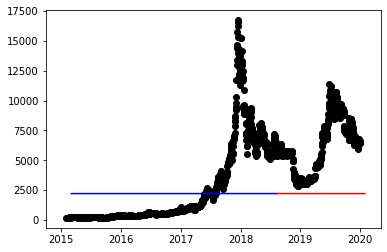

In [189]:
plt.scatter(df["time"].values,df["prices"], color="black")
plt.plot((df_train["time"]+pd.DateOffset(days=30)).values,df_train["Forecast"].values, color="blue")
plt.plot((df_test["time"]+pd.DateOffset(days=30)).values,df_test["Forecast"].values, color="red")

plt.show()

## Basic Layer Model with MinMaxScaler 

In [190]:
X=np.array(df_train["Time"])
X=X.reshape(-1,1)

scaler=preprocessing.MinMaxScaler()
X_scaled=scaler.fit_transform(X)

y=np.array(df_train["PricesFuture"])

In [191]:
model = tf.keras.Sequential([
#tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
tf.keras.layers.Dense(10, activation='sigmoid', input_shape=(1,)),
##tf.keras.layers.Dense(20, activation='sigmoid', input_shape=(1,)),

#tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(10, activation='sigmoid'),
#tf.keras.layers.Dense(20, activation='sigmoid'),

#tf.keras.layers.Dense(10, activation='relu')
tf.keras.layers.Dense(20, activation='relu'),
tf.keras.layers.Dense(1)
])

model.compile(#optimizer=tf.compat.v1.train.AdamOptimizer(0.001),
              optimizer=tf.compat.v1.train.AdamOptimizer(0.01),
              loss="mse",
              metrics=["mae"])  


model.fit(X_scaled,y, epochs=30 , batch_size=10 )
#model.fit(X_scaled,y, epochs=100 , batch_size=10 )

forecast_train=model.predict(X_scaled)
df_train["Forecast"]= forecast_train

Train on 1255 samples
Epoch 1/30
1255/1255 [==============================] - 4s 3ms/sample - loss: 15251276.4023 - mae: 2180.4585
Epoch 2/30
1255/1255 [==============================] - 1s 910us/sample - loss: 13906979.1586 - mae: 1959.2275
Epoch 3/30
1255/1255 [==============================] - 1s 855us/sample - loss: 12181520.9041 - mae: 1968.2600
Epoch 4/30
1255/1255 [==============================] - 1s 1ms/sample - loss: 11028935.6668 - mae: 2125.0769 0s - loss: 11214564.0827 - mae: 20
Epoch 5/30
1255/1255 [==============================] - 2s 1ms/sample - loss: 10616461.5667 - mae: 2316.6560
Epoch 6/30
1255/1255 [==============================] - 2s 1ms/sample - loss: 10521303.4153 - mae: 2365.1680
Epoch 7/30
1255/1255 [==============================] - 1s 896us/sample - loss: 10499213.9741 - mae: 2386.5923
Epoch 8/30
1255/1255 [==============================] - 1s 902us/sample - loss: 10496952.8675 - mae: 2427.7991
Epoch 9/30
1255/1255 [==============================] - 1s 1ms/

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [192]:
X_test=np.array(df_test["Time"])
X_test=X_test.reshape(-1,1)

X_testscaled=scaler.transform(X_test)
forecast_test=model.predict(X_testscaled)
df_test["Forecast"]=forecast_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


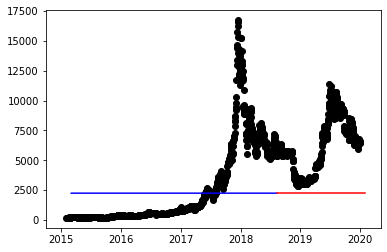

In [193]:
plt.scatter(df["time"].values,df["prices"], color="black")
plt.plot((df_train["time"]+pd.DateOffset(days=30)).values,df_train["Forecast"].values, color="blue")
plt.plot((df_test["time"]+pd.DateOffset(days=30)).values,df_test["Forecast"].values, color="red")

plt.show()

In [195]:
df_validation=df_test.dropna()
print("The mean absolute error of the prediction in the test data is% .f"%
      mean_absolute_error(df_validation["PricesFuture"],
                          df_validation["Forecast"]))


The mean absolute error of the prediction in the test data is 3831


In [196]:
model = tf.keras.Sequential([
#tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
tf.keras.layers.Dense(10, activation='sigmoid', input_shape=(1,)),
##tf.keras.layers.Dense(20, activation='sigmoid', input_shape=(1,)),

#tf.keras.layers.Dense(10, activation='relu'),
#tf.keras.layers.Dense(10, activation='sigmoid'),
tf.keras.layers.Dense(20, activation='sigmoid'),

#tf.keras.layers.Dense(10, activation='relu')
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(1)
])

model.compile(#optimizer=tf.compat.v1.train.AdamOptimizer(0.001),
              optimizer=tf.compat.v1.train.AdamOptimizer(0.01),
              loss="mse",
              metrics=["mae"])  


model.fit(X_scaled,y, epochs=35 , batch_size=10 )
#model.fit(X_scaled,y, epochs=100 , batch_size=10 )

forecast_train=model.predict(X_scaled)
df_train["Forecast"]= forecast_train

Train on 1255 samples
Epoch 1/35
1255/1255 [==============================] - 3s 2ms/sample - loss: 14986312.2788 - mae: 2122.7585
Epoch 2/35
1255/1255 [==============================] - 1s 963us/sample - loss: 12600783.7780 - mae: 1956.1315
Epoch 3/35
1255/1255 [==============================] - 1s 1ms/sample - loss: 10885982.5045 - mae: 2200.0740
Epoch 4/35
1255/1255 [==============================] - 1s 898us/sample - loss: 10527455.0468 - mae: 2378.6797
Epoch 5/35
1255/1255 [==============================] - 1s 857us/sample - loss: 10498808.6195 - mae: 2421.8887
Epoch 6/35
1255/1255 [==============================] - 1s 757us/sample - loss: 10499716.8257 - mae: 2416.3047
Epoch 7/35
1255/1255 [==============================] - 1s 720us/sample - loss: 10499691.8486 - mae: 2422.8369
Epoch 8/35
1255/1255 [==============================] - 2s 1ms/sample - loss: 10496211.7530 - mae: 2413.5176
Epoch 9/35
1255/1255 [==============================] - 1s 946us/sample - loss: 10495691.2410 - 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [197]:
X_test=np.array(df_test["Time"])
X_test=X_test.reshape(-1,1)

X_testscaled=scaler.transform(X_test)
forecast_test=model.predict(X_testscaled)
df_test["Forecast"]=forecast_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


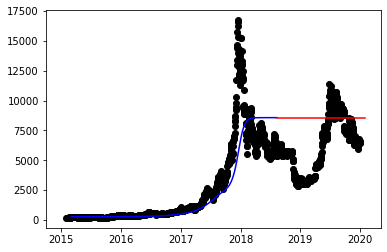

In [198]:
plt.scatter(df["time"].values,df["prices"], color="black")
plt.plot((df_train["time"]+pd.DateOffset(days=30)).values,df_train["Forecast"].values, color="blue")
plt.plot((df_test["time"]+pd.DateOffset(days=30)).values,df_test["Forecast"].values, color="red")

plt.show()

In [199]:
model = tf.keras.Sequential([
#tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
tf.keras.layers.Dense(10, activation='sigmoid', input_shape=(1,)),
##tf.keras.layers.Dense(20, activation='sigmoid', input_shape=(1,)),

#tf.keras.layers.Dense(10, activation='relu'),
#tf.keras.layers.Dense(10, activation='sigmoid'),
tf.keras.layers.Dense(20, activation='sigmoid'),

#tf.keras.layers.Dense(10, activation='relu')
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(0.001),
              #optimizer=tf.compat.v1.train.AdamOptimizer(0.01),
              loss="mse",
              metrics=["mae"])  


model.fit(X_scaled,y, epochs=35 , batch_size=10 )
#model.fit(X_scaled,y, epochs=100 , batch_size=10 )

forecast_train=model.predict(X_scaled)
df_train["Forecast"]= forecast_train

Train on 1255 samples
Epoch 1/35
1255/1255 [==============================] - 4s 3ms/sample - loss: 15490696.5878 - mae: 2236.3982
Epoch 2/35
1255/1255 [==============================] - 1s 898us/sample - loss: 15423402.1815 - mae: 2220.4221s - loss: 18481460.3906 - 
Epoch 3/35
1255/1255 [==============================] - 1s 928us/sample - loss: 15273800.8206 - mae: 2187.1348
Epoch 4/35
1255/1255 [==============================] - 1s 708us/sample - loss: 15059937.9609 - mae: 2136.5105
Epoch 5/35
1255/1255 [==============================] - 2s 1ms/sample - loss: 14797763.3400 - mae: 2075.0034
Epoch 6/35
1255/1255 [==============================] - 1s 838us/sample - loss: 14503420.4619 - mae: 2012.8490
Epoch 7/35
1255/1255 [==============================] - 1s 660us/sample - loss: 14183854.6346 - mae: 1967.0587
Epoch 8/35
1255/1255 [==============================] - 3s 3ms/sample - loss: 13846696.1217 - mae: 1933.0743
Epoch 9/35
1255/1255 [==============================] - 4s 3ms/sample 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [200]:
X_test=np.array(df_test["Time"])
X_test=X_test.reshape(-1,1)

X_testscaled=scaler.transform(X_test)
forecast_test=model.predict(X_testscaled)
df_test["Forecast"]=forecast_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


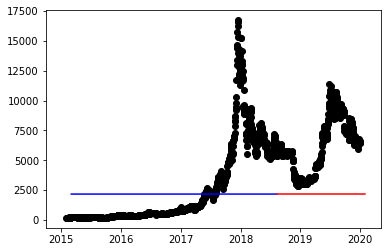

In [201]:
plt.scatter(df["time"].values,df["prices"], color="black")
plt.plot((df_train["time"]+pd.DateOffset(days=30)).values,df_train["Forecast"].values, color="blue")
plt.plot((df_test["time"]+pd.DateOffset(days=30)).values,df_test["Forecast"].values, color="red")

plt.show()